In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

### Importing Data Loader and Featurizer Script for Custom Featurization

In [ ]:
# Get the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

# Import featurizer function and the data folder path.
from scripts.data_loader_and_featurizer import run_featurizer, data_path

In [ ]:
# run the featurization process using the Morgan fingerprint model for my
# datast split file and generates output files and saving them to `data_path`.

input_filenames = ["train_features.csv", "valid_features.csv", "test_features.csv"]
output_filenames = ["morgan_train_features.csv", "morgan_valid_features.csv", "morgan_test_features.csv"]
morgan_id = 'eos4wt0'
run_featurizer(model_id=morgan_id, input_filenames= input_filenames, output_filenames= output_filenames, data_path=data_path)

In [177]:
# run the featurization process using Compound Embeddings.
input_filenames = ["train_features.csv", "valid_features.csv", "test_features.csv"]
output_filenames = ["ComPEmbed_train_features.csv", "CompEmbed_valid_features.csv", "CompEmbed_test_features.csv"]
morgan_id = 'eos2gw4'
run_featurizer(model_id=morgan_id, input_filenames= input_filenames, output_filenames= output_filenames, data_path=data_path)

In [29]:
# Load the Morgan featureized & display first row to verify the data structure.
morgan_train_features_df = pd.read_csv(data_path/"morgan_train_features.csv")
morgan_train_features_df.head(1)

,key,input,dimension_0000,dimension_0001,dimension_0002,dimension_0003,dimension_0004,dimension_0005,dimension_0006,dimension_0007,...,dimension_2038,dimension_2039,dimension_2040,dimension_2041,dimension_2042,dimension_2043,dimension_2044,dimension_2045,dimension_2046,dimension_2047
0,d13830395235619cda85ecea54cda393,CCOCc1cc(OC)c(B(O)O)c(OC)c1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### EDA: Doing some EDA for the original skin dataset from TDC.

In [124]:
# Load dataset and display 5 random samples

dataset = pd.read_csv(data_path/"skin_reaction.csv")
dataset.sample(5)

,Drug_ID,Drug,Y
402,Propyl gallate,CCCOC(=O)c1cc(O)c(O)c(O)c1,1
110,Pentaerythritol triacrylate,C=CC(=O)OCC(CO)(COC(=O)C=C)COC(=O)C=C,0
174,6-Methylisoeugenol,CC=Cc1cc(C)c(O)c(OC)c1,1
94,Isopropanol,CC(C)O,0
320,Benzalkonium chloride,CCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1,1


In [31]:
# printing data shape
"Shape of the dataset is {}.Contains {} rows and {} columns".format(dataset.shape,dataset.shape[0],dataset.shape[1])

'Shape of the dataset is (404, 3).Contains 404 rows and 3 columns'

Tabular summary of columns, non-null counts, and data types.: Our data has no null values 

In [169]:
pd.DataFrame({
    "Column": dataset.columns,
    "Non-Null Count": dataset.notnull().sum().values,
    "Dtype": dataset.dtypes.replace("object", "string").values # Show dtype object as string
})

,Column,Non-Null Count,Dtype
0,Drug_ID,404,string
1,Drug,404,string
2,Y,404,int64


**Data Uniqueness**: All our 404 rows are uniue molecules. There's no duplicates.

In [93]:
dataset.nunique().to_frame().rename(columns={0: 'Unique Values'})

,Unique Values
Drug_ID,404
Drug,404
Y,2


#### Class Balance:

The dataset is imbalanced, with the count of **skin sensitizers (class 1)** being twice as large as the count of **non-sensitizers (class 0)**. This skew towards the positive (sensitizers)class could bias model training, so techniques like resampling may be necessary.

In [128]:
value_counts = dataset['Y'].value_counts()
value_counts.to_frame()

,count
Y,
1,274
0,130


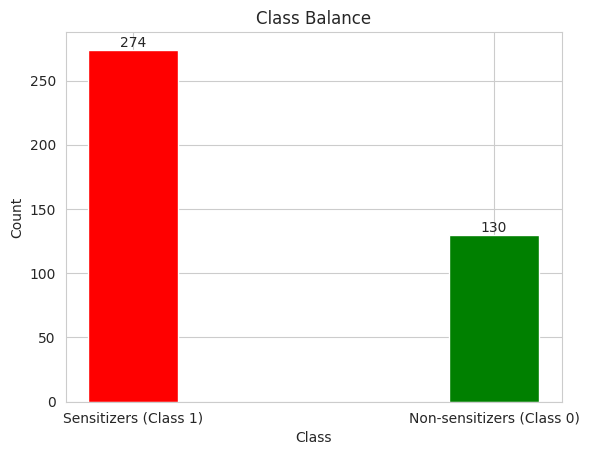

In [138]:
value_counts = dataset['Y'].value_counts()

# Define colors and labels dynamically based on the sorted order
class_mapping = {0: 'Non-sensitizers (Class 0)', 1: 'Sensitizers (Class 1)'}
colors = ['green' if idx == 0 else 'red' for idx in value_counts.index]
labels = [class_mapping[idx] for idx in value_counts.index]

# Create bar chart
bars = plt.bar(range(len(value_counts)), value_counts.values, color=colors, width=0.25)

# Add value labels on top of each bar>
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Set the x-axis labels
plt.xticks(range(len(value_counts)), labels)

# Set labels & title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Balance')

# Show plot
plt.show()


#### SMILES Length Analysis: Stats of complexity/size in `Drug` column:
- Most molecules are relatively small, hist peaking between 10–25 characters and a median length of 22. indicates simple structure.

- We have a right skewed distribution with a mean of 25 and a wide range of 4: 98, which highlights a long tail of complex molecules

- A standard deviation of 16 indicates significant variability relative to our 25 mean.

In [157]:
smiles_length = dataset['Drug'].str.len()
smiles_length.describe().to_frame().round(1)

,Drug
count,404.0
mean,25.4
std,15.9
min,4.0
25%,15.8
50%,22.0
75%,30.0
max,98.0


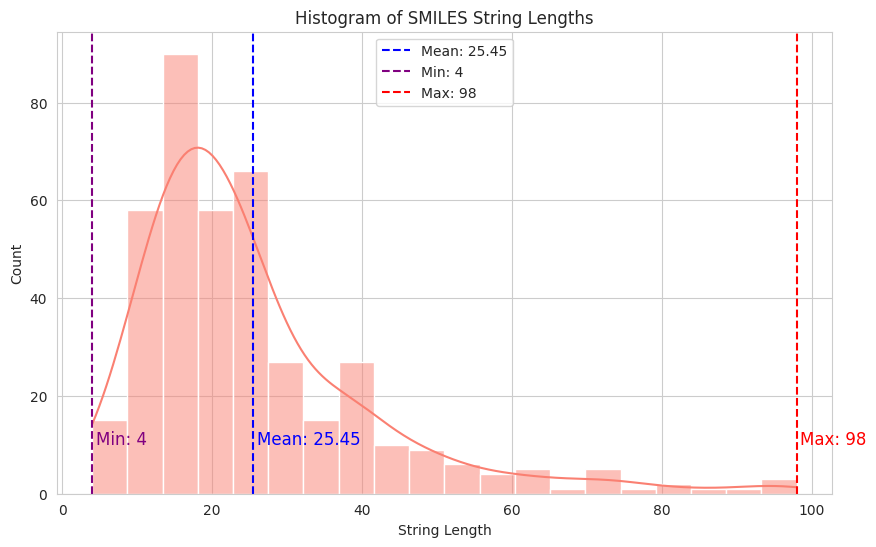

In [161]:

# Calculate summary statistics
mean_length = smiles_length.mean()
std_dev = smiles_length.std()
min_length = smiles_length.min()
max_length = smiles_length.max()

# Create the histogram (show counts)
plt.figure(figsize=(10, 6))
sns.histplot(smiles_length, kde=True, bins=20, color='salmon', stat='count')

# Adding summary stats to the plot
plt.axvline(mean_length, color='blue', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(min_length, color='purple', linestyle='--', label=f'Min: {min_length}')
plt.axvline(max_length, color='red', linestyle='--', label=f'Max: {max_length}')

# Annotate the stats on the plot
plt.text(mean_length + 0.5, 10, f'Mean: {mean_length:.2f}', color='blue', fontsize=12)
plt.text(min_length + 0.5, 10, f'Min: {min_length}', color='purple', fontsize=12)
plt.text(max_length + 0.5, 10, f'Max: {max_length}', color='red', fontsize=12)

# Customize the plot labels and title
plt.title('Histogram of SMILES String Lengths')
plt.xlabel('String Length')
plt.ylabel('Count')

# Show the plot with summary stats
plt.legend()
plt.show()
